#                                        Restaurant Revenue Prediction

# **Introduction:**

Food industry plays a crucial part in the enhancement of the country’s economy. This mainly plays a key role in metropolitan cities. Where restaurants are essential parts of social gatherings and in recent days there are different varieties of quick-service restaurants like food trucks and takeaways. With this recent rise in restaurant types, it is difficult to decide when and where to open a new restaurant. 


**Overview of the competition:**

Over 1,200 quick service restaurants across the globe, TFI is the company where it owns several well-known restaurants across different parts of the Europe and Asia.They employ over 20,000 people in Europe and Asia and make significant daily investments in developing new restaurant sites.
We have been encountered with four different types of restaurants. They are inline, mobile, drive-thru, and food court. So deciding to open a new restaurant is challenging with these emerging quick-service restaurants.   

In recent days, even restaurant sites also include a large investment of time and capital. Geographical locations and cultures also impact the long-time survival of the firm.
With the subjective data, it is difficult to extrapolate the place where to open a new restaurant. So TF1 needs a model such that they can effectively invest in new restaurant sites. This competition is to predict the annual restaurant sales of 100,000 regional locations.


**Type of Machine learning problem:**

We are asked to predict the revenue of the restaurant in a given year, this problem can be best framed as a Regression problem.


# **Data Overview:**

Dataset: https://www.kaggle.com/c/restaurant-revenue-prediction/data

TFI company has provided a dataset with 137 restaurants in training phase and 100,000 restaurants for testing phase.
*   Id: Restaurant ID
*   Open Date: Opening date of a restaurant
*   City:  City where restaurant is located
*   City Group: Type of the city. Big cities, or Other.
*   Type: Type of the restaurant. FC: Food Court, IL: Inline, DT: Drive Thru,   MB: Mobile
*   P1- P37: There are three categories of these obfuscated data.
    *   Demographic data are gathered from third party providers with GIS systems. 
These include population in any given area, age and gender distribution, development scales.
    *   Real estate data mainly relate to the m2 of the location, front facade of the location, car park availability.

    *  Commercial data mainly include the existence of points of interest including schools, banks, other QSR operators.
*   Revenue: The revenue column indicates transformed revenue of the restaurant in a given year and is the target of predictive analysis

City, City Group, Type are categorical variables.\
P1-P37, Revenue are continuous variables.


# **Evaluation Metric:**

Let's discuss here with most efficient and commonly used evaluation metrics in regression problems.\
**Root Mean Squared Error(RMSE):** \
**RMSE** is the most popular evaluation metric where it follows an assumption that errors obtained are unbiased and follow a normal distribution. RMSE is the square root of average squared residuals/errors. \
Residuals = y_actual - y_predicted
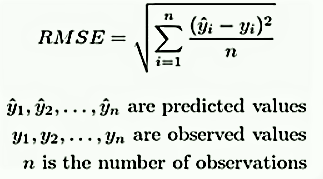

Here, the errors are squared before they get averaged, this implies that higher weight is assigned to larger errors which means model performance gets drastically affected when large errors are present. \
The **Squareroot** in RMSE makes the scale of the errors be in scale as the scale of the target variable. \
Example: Let's consider target variable 'revenue' has its unit in 'dollars', then RMSE will have its unit in 'dollars'. \
The **Square term** in RMSE prevents canceling the positive and negative error values. \
As RMSE is highly affected by outlier values, it is mandatory to handle outliers from the data before using this metric. 
Lower the value better is the performance of the model.

**Root Mean Squared Logarithmic Error(RMSLE):** \
**RMSLE** is similar to RMSE but where the error term is calculated at a logarithmic scale. \
In the case of RMSE, the presence of outliers increases the error term to a very large value. But, in the case of RMLSE, the outliers are drastically scaled-down. When we don't want to influence results, if there are large errors then RMSLE can be taken into consideration. \
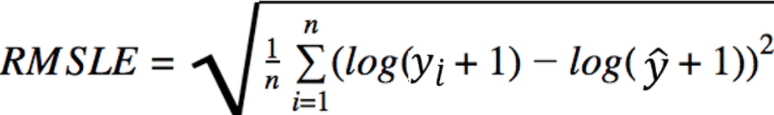
 \
Here we are adding 1 as a constant to both actual and predicted values because if the logarithmic term is 0 then it reaches infinitely large. \

Predicted value - SMALL &  Actual value - SMALL : RMSE and RMSLE are same \
Either Predicted value or  Actual value - LARGE : RMSE > RMSLE \
Predicted value - LARGE  &  Actual value - LARGE : RMSE > RMSLE

In this dataset, actual and predicted values are large. Hence we can consider RMSE as an evaluation metric.

In [ ]:
pip install phik

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error 
from sklearn.tree import DecisionTreeRegressor
import phik
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [45]:
train = pd.read_csv("/home/dosecurity/Desktop/PythonProjects/ProjectFolder/mlops-project-dic3/data/input/train.csv.zip")
train.head(2)

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0


In [46]:
test = pd.read_csv("/home/dosecurity/Desktop/PythonProjects/ProjectFolder/mlops-project-dic3/data/input/test.csv.zip")
test.head(2)

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,2.0,3.0,0,0,0,0,0,0,0,0
1,1,03/18/2011,Konya,Other,IL,3,4.0,4.0,4.0,2,...,1.0,3.0,0,0,0,0,0,0,0,0


**Adding new features from 'Open Date' variable**

In [26]:
#generating new features from 'Open Date' feature
def newFeatures(df):
  df['Date'] = pd.to_datetime(df['Open Date'],format="%m/%d/%Y")
  df['Year'] = df['Date'].dt.year
  df['Month'] = df['Date'].dt.month
  df['Years Old'] = pd.to_datetime('23-03-2015').year - df['Date'].dt.year
  df = df.drop(['Open Date','Date'],axis=1)
  return df

In [27]:
#Reordering columns
def reorderingCols(train_data,test_data):
    train = train_data[['Id','City','City Group','Type','Year','Month','Years Old','P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','P11','P12','P13','P14','P15','P16','P17','P18','P19','P20','P21','P22','P23','P24','P25','P26','P27','P28','P29','P30','P31','P32','P33','P34','P35','P36','P37','revenue']]
    test = test_data[['Id','City','City Group','Type','Year','Month','Years Old','P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','P11','P12','P13','P14','P15','P16','P17','P18','P19','P20','P21','P22','P23','P24','P25','P26','P27','P28','P29','P30','P31','P32','P33','P34','P35','P36','P37']]
    return train,test

Handling Outliers

In [28]:
#Even after logarithmic transformation of 'revenue' variable still there exists skewness. So lets drop few outliers.
def handlingOutliers(train):
  train = train[train['revenue']<train['revenue'].quantile(0.98)] 
  return train

Handling numerical

In [37]:
def numFea(train_data):
    #To find highly correlated independent features.
    num_fea = train_data.drop(['Id','revenue','City Group', 'City','Type'],axis=1)
    corr = num_fea.corr()
    #https://www.dezyre.com/recipes/drop-out-highly-correlated-features-in-python
    upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))  #numerical features that are highly correlated with each other
    corr_col = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]

    Phi_corr = train_data.drop(['Id'],axis=1).phik_matrix()
    fea = train_data.drop(['Id','revenue'],axis=1)
    Phi_corrFea = (Phi_corr['revenue'].sort_values(ascending=False)==0) #Features that have zero or no correlation with target variable
    no_cor = [col for col in fea.columns if Phi_corrFea[col]==True]

    drop_num = [col for col in corr_col if col not in no_cor]  #Dropping Features that are having zero correlation with the target variable but are highly correlated with other variables  
    return drop_num

ici l'objectif de voir les corrélations les éleves entre les différentes variables quantitatives et matcher ça avec la corrélation faite entre la variable  target et les autres variables catégorielles tant que  en utilisant la bibliothèque phik : ce qui signifie on va supprimer les variables qui n'ont pas de corrélation avec la variable target donc ne n'ayant pas beaucoup d'impact sur la variable target et qui sont très corréles avec les autres variables la corrélation supèrieur à 0.8 donc ces variables se ressemblent donc on peut utiliser qu'une des deux variables

Handling categorical

In [30]:
def catFea(df):
  labelEncoding = LabelEncoder()
  df['City Group'] = labelEncoding.fit_transform(df['City Group'].astype('str'))
  df['Type'] = labelEncoding.fit_transform(df['Type'].astype('str'))
  return df

Splitting X & y

In [31]:
#City can be dropped because there are 23 cities in test that are unseen during training phase
def split_X_y(train_data,test_data):
    y_train = train_data['revenue']
    X_train = train_data.drop(['Id','revenue','City'],axis=1)
    X_test = test_data.drop(['Id','City'],axis=1)
    return X_train,X_test,y_train

Stanadard Scaler follows standard normal distribution where mean is centered to zero and scales data to unit variance

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# transform data
def scaling(X_train,X_test):
    X_train_scale = scaler.fit_transform(X_train)
    X_test_scale = scaler.transform(X_test)
    return X_train_scale,X_test_scale

As there is high dimensionality in data we can use Principal Component Analysis(PCA). It helps in reducing the dimensions of data and focus on the ones with the largest variance components.


In [33]:
from sklearn.decomposition import PCA
#https://www.geeksforgeeks.org/principal-component-analysis-with-python/
def principalComponentAnalysis(X_train,X_test):
    pca = PCA(n_components = 10)
    X_train_PCA = pca.fit_transform(X_train) 
    X_test_PCA = pca.transform(X_test) 
    return X_train_PCA,X_test_PCA

Feature Engineering Pipeline

In [47]:
def featureEngineering(train,test):

    #generating new features
    train = newFeatures(train)
    if 'Open Date' in test:
        test = newFeatures(test)
    
    #Reordering columns
    train,test = reorderingCols(train,test)
    

    #Handling numerical features
    dropnum = numFea(train)
    train  = train.drop(dropnum,axis=1)
    test = test.drop(dropnum,axis=1)

    #Handling outliers
    train = handlingOutliers(train)

    #Handling categorical features
    train = catFea(train) 
    test = catFea(test)  

    #Split X & y
    X_train,X_test,y_train = split_X_y(train,test)

    #Standard Scaling
    X_train_scale,X_test_scale = scaling(X_train,X_test)
    
     #Principal Component Analysis
    X_train_PCA,X_test_PCA = principalComponentAnalysis(X_train,X_test)

    return X_train,X_train_scale,X_test_scale,y_train,  X_train_PCA,X_test_PCA

In [48]:
X_train,X_train_scale,X_test_scale,y_train, X_train_PCA,X_test_PCA = featureEngineering(train,test)

interval columns not set, guessing: ['Year', 'Month', 'Years Old', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'revenue']


/tmp/ipykernel_84461/409612131.py:6: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Years Old'] = pd.to_datetime('23-03-2015').year - df['Date'].dt.year
/tmp/ipykernel_84461/409612131.py:6: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Years Old'] = pd.to_datetime('23-03-2015').year - df['Date'].dt.year
/tmp/ipykernel_84461/34042890.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr.where(np.triu(np.ones(corr.sha

model fitting

In [49]:
def predict_model(model,X,y_act):
    y_pred = model.predict(X)
    rms = mean_squared_error(y_act, y_pred,squared=False)
    return rms

### Linear avec le Lasso Regression

In [54]:
from sklearn import linear_model
model_LR1 = linear_model.LassoCV(max_iter=10000,alphas=(0.0001,0.01,0.1,1),n_alphas=300,cv=5)
model_LR1.fit(X_train_scale,y_train)
LR_rmse1 = predict_model(model_LR1,X_train_scale,y_train)
print('Train RMSE score :',LR_rmse1)

Train RMSE score : 1553197.671562635


applying pca

In [57]:
model_LR2 = linear_model.LassoCV(max_iter=100000,alphas=(0.0001,0.01,0.1,1),n_alphas=1000,cv=5)
model_LR2.fit(X_train_PCA,y_train)
LR_rmse2 = predict_model(model_LR2,X_train_PCA,y_train)
print('Train RMSE score :',LR_rmse2)

Train RMSE score : 1710660.380771704


### Random Forest

In [58]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

params = {
    "n_estimators": randint(10,1000),
    "max_depth": randint(1,10),
    "min_samples_split": uniform(0.1,0.8),
    'max_features':['auto', 'sqrt', 'log2']
}

RF_model = RandomForestRegressor()
model_rf1 = RandomizedSearchCV(RF_model, params, cv=6, n_iter=100, scoring='neg_mean_squared_error', return_train_score=True, verbose=3, n_jobs=-1)
model_rf1.fit(X_train_scale, y_train)
RF_rmse1 = predict_model(model_rf1, X_train_scale, y_train)
print('Train RMSE score :',RF_rmse1)

Fitting 6 folds for each of 100 candidates, totalling 600 fits
[CV 2/6] END max_depth=6, max_features=sqrt, min_samples_split=0.8798369428899177, n_estimators=495;, score=(train=-3394711188851.042, test=-2347982189076.512) total time=   0.7s
[CV 4/6] END max_depth=1, max_features=sqrt, min_samples_split=0.7495211900696056, n_estimators=954;, score=(train=-3426209938164.763, test=-2146006539908.043) total time=   1.3s
[CV 5/6] END max_depth=3, max_features=log2, min_samples_split=0.7182901096773039, n_estimators=746;, score=(train=-3182223113599.295, test=-3375748596254.030) total time=   1.0s
[CV 1/6] END max_depth=4, max_features=sqrt, min_samples_split=0.3434646862824928, n_estimators=685;, score=(train=-2685619087221.663, test=-2643207551454.428) total time=   1.1s
[CV 1/6] END max_depth=8, max_features=sqrt, min_samples_split=0.3853332743033935, n_estimators=345;, score=(train=-2752613781002.732, test=-2700358288256.242) total time=   0.5s
[CV 1/6] END max_depth=8, max_features=sqr

[CV 4/6] END max_depth=7, max_features=log2, min_samples_split=0.6304749891215671, n_estimators=123;, score=(train=-3222123376318.906, test=-2005892067839.286) total time=   0.2s
[CV 6/6] END max_depth=6, max_features=sqrt, min_samples_split=0.8798369428899177, n_estimators=495;, score=(train=-2983885663306.095, test=-4437458869947.511) total time=   0.7s
[CV 2/6] END max_depth=7, max_features=sqrt, min_samples_split=0.4865481818967433, n_estimators=211;, score=(train=-2887097957737.192, test=-2247163492576.815) total time=   0.3s
[CV 4/6] END max_depth=7, max_features=sqrt, min_samples_split=0.4865481818967433, n_estimators=211;, score=(train=-2936892514870.412, test=-1894988546720.711) total time=   0.3s
[CV 6/6] END max_depth=7, max_features=sqrt, min_samples_split=0.4865481818967433, n_estimators=211;, score=(train=-2463849763035.478, test=-4778283830625.053) total time=   0.3s
[CV 4/6] END max_depth=3, max_features=log2, min_samples_split=0.7182901096773039, n_estimators=746;, sco

[CV 1/6] END max_depth=7, max_features=log2, min_samples_split=0.6304749891215671, n_estimators=123;, score=(train=-3067835816779.290, test=-2891765701820.975) total time=   0.2s
[CV 3/6] END max_depth=6, max_features=sqrt, min_samples_split=0.8798369428899177, n_estimators=495;, score=(train=-3026325492938.366, test=-4177587986226.190) total time=   0.7s
[CV 5/6] END max_depth=1, max_features=sqrt, min_samples_split=0.7495211900696056, n_estimators=954;, score=(train=-3182598568412.973, test=-3376330809015.237) total time=   1.3s
[CV 1/6] END max_depth=3, max_features=sqrt, min_samples_split=0.7374140015443164, n_estimators=849;, score=(train=-3264476919115.786, test=-2972607579515.312) total time=   1.2s
[CV 4/6] END max_depth=4, max_features=sqrt, min_samples_split=0.3434646862824928, n_estimators=685;, score=(train=-2788202710281.896, test=-1886622978201.679) total time=   1.1s
[CV 6/6] END max_depth=8, max_features=sqrt, min_samples_split=0.3853332743033935, n_estimators=345;, sco

[CV 6/6] END max_depth=7, max_features=log2, min_samples_split=0.6304749891215671, n_estimators=123;, score=(train=-2750599997783.969, test=-4539511522236.657) total time=   0.2s
[CV 2/6] END max_depth=1, max_features=sqrt, min_samples_split=0.7495211900696056, n_estimators=954;, score=(train=-3394804677458.205, test=-2344553205735.203) total time=   1.3s
[CV 2/6] END max_depth=3, max_features=log2, min_samples_split=0.7182901096773039, n_estimators=746;, score=(train=-3394734482423.078, test=-2345660779957.777) total time=   1.0s
[CV 4/6] END max_depth=3, max_features=sqrt, min_samples_split=0.7374140015443164, n_estimators=849;, score=(train=-3426178829644.912, test=-2144246642319.582) total time=   1.3s
[CV 6/6] END max_depth=4, max_features=sqrt, min_samples_split=0.3434646862824928, n_estimators=685;, score=(train=-2247855334382.288, test=-4859342108095.751) total time=   1.0s
[CV 4/6] END max_depth=4, max_features=log2, min_samples_split=0.7038887952083138, n_estimators=237;, sco

Train RMSE score : 1574549.756777705


/home/dosecurity/Desktop/notebooks/notebookEnv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
174 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/home/dosecurity/Desktop/notebooks/notebookEnv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/dosecurity/Desktop/notebooks/notebookEnv/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/home/dosecurity/Desktop/notebooks/notebookEnv/lib/python3.11/site-packages/

In [59]:
model_rf1.best_estimator_

RandomForestRegressor(max_depth=6, max_features='sqrt',
                      min_samples_split=0.2747483179231822, n_estimators=85)

applying PCA

In [60]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
params = {
    "n_estimators": randint(10,1000),
    "max_depth": randint(1,10),
    "min_samples_split": uniform(0.1,0.8),
    'max_features':['auto', 'sqrt', 'log2']
}

RF_model = RandomForestRegressor()
model_rf2 = RandomizedSearchCV(RF_model, params, cv=2, n_iter=100, scoring='neg_mean_squared_error', return_train_score=True, verbose=3, n_jobs=-1)
model_rf2.fit(X_train_PCA, y_train)
RF_rmse2 = predict_model(model_rf2, X_train_PCA, y_train)
print('Train RMSE score :',RF_rmse2)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
[CV 1/6] END max_depth=8, max_features=log2, min_samples_split=0.7954296828315958, n_estimators=180;, score=(train=-3264738172005.608, test=-2973607531054.498) total time=   0.4s
[CV 2/6] END max_depth=8, max_features=log2, min_samples_split=0.7954296828315958, n_estimators=180;, score=(train=-3395043472966.449, test=-2352417774290.501) total time=   0.4s
[CV 3/6] END max_depth=7, max_features=sqrt, min_samples_split=0.5310839757313688, n_estimators=321;, score=(train=-2677446684245.464, test=-3736126454173.484) total time=   0.5s
[CV 4/6] END max_depth=7, max_features=sqrt, min_samples_split=0.5310839757313688, n_estimators=321;, score=(train=-2984429254200.738, test=-1869172989133.876) total time=   0.5s
[CV 1/6] END max_depth=7, max_features=auto, min_samples_split=0.8495798002142653, n_estimators=456;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/6] END max_depth=7, max_features=auto, min_samples_split=0.8495798

[CV 6/6] END max_depth=2, max_features=sqrt, min_samples_split=0.43835734265496074, n_estimators=125;, score=(train=-2465105950965.745, test=-4701907153793.464) total time=   0.2s
[CV 5/6] END max_depth=5, max_features=log2, min_samples_split=0.32368949492053406, n_estimators=492;, score=(train=-2510975872922.919, test=-3125898780391.610) total time=   0.7s
[CV 6/6] END max_depth=5, max_features=log2, min_samples_split=0.32368949492053406, n_estimators=492;, score=(train=-2236338260227.883, test=-4885136839589.291) total time=   0.8s
[CV 3/6] END max_depth=9, max_features=sqrt, min_samples_split=0.6079993750114975, n_estimators=502;, score=(train=-2788792350960.066, test=-3845895417473.776) total time=   1.0s
[CV 4/6] END max_depth=9, max_features=sqrt, min_samples_split=0.6079993750114975, n_estimators=502;, score=(train=-3151249360927.750, test=-1966699837304.206) total time=   0.9s
[CV 1/6] END max_depth=8, max_features=log2, min_samples_split=0.649180722885684, n_estimators=43;, sc

/home/dosecurity/Desktop/notebooks/notebookEnv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
76 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
52 fits failed with the following error:
Traceback (most recent call last):
  File "/home/dosecurity/Desktop/notebooks/notebookEnv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/dosecurity/Desktop/notebooks/notebookEnv/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/home/dosecurity/Desktop/notebooks/notebookEnv/lib/python3.11/site-packages/sk

Train RMSE score : 1631510.088224402
[CV 4/6] END max_depth=8, max_features=log2, min_samples_split=0.7954296828315958, n_estimators=180;, score=(train=-3426227245214.680, test=-2146586528504.726) total time=   0.3s
[CV 1/6] END max_depth=7, max_features=log2, min_samples_split=0.794379056630461, n_estimators=800;, score=(train=-3264514229180.805, test=-2972972632089.250) total time=   1.2s
[CV 2/6] END max_depth=7, max_features=log2, min_samples_split=0.794379056630461, n_estimators=800;, score=(train=-3394774631227.846, test=-2344951359969.394) total time=   1.4s
[CV 5/6] END max_depth=1, max_features=sqrt, min_samples_split=0.6575765931959449, n_estimators=684;, score=(train=-3097627897174.574, test=-3339496323057.994) total time=   1.5s
[CV 3/6] END max_depth=9, max_features=sqrt, min_samples_split=0.5321396537968365, n_estimators=63;, score=(train=-2658968688378.502, test=-3819814114229.428) total time=   0.2s
[CV 2/6] END max_depth=4, max_features=sqrt, min_samples_split=0.554471

[CV 1/2] END max_depth=3, max_features=auto, min_samples_split=0.5844016177062263, n_estimators=981;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/2] END max_depth=3, max_features=auto, min_samples_split=0.5844016177062263, n_estimators=981;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/2] END max_depth=7, max_features=log2, min_samples_split=0.4403517996085353, n_estimators=370;, score=(train=-2605510091131.716, test=-3117076975518.376) total time=   0.5s
[CV 2/2] END max_depth=7, max_features=log2, min_samples_split=0.4403517996085353, n_estimators=370;, score=(train=-2221358820667.545, test=-3215582623051.255) total time=   0.5s
[CV 1/2] END max_depth=9, max_features=sqrt, min_samples_split=0.5461470797335548, n_estimators=471;, score=(train=-2720754054992.526, test=-3134919612305.695) total time=   0.7s
[CV 1/2] END max_depth=1, max_features=auto, min_samples_split=0.53505229843905, n_estimators=75;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/2] END max_de

[CV 5/6] END max_depth=2, max_features=log2, min_samples_split=0.1946679227744438, n_estimators=515;, score=(train=-2638465293657.306, test=-3194539264251.246) total time=   1.1s
[CV 6/6] END max_depth=2, max_features=log2, min_samples_split=0.1946679227744438, n_estimators=515;, score=(train=-2287854146585.569, test=-4785881190529.443) total time=   1.1s
[CV 5/6] END max_depth=7, max_features=sqrt, min_samples_split=0.5310839757313688, n_estimators=321;, score=(train=-2749381563991.745, test=-3211081343006.219) total time=   0.5s
[CV 6/6] END max_depth=7, max_features=sqrt, min_samples_split=0.5310839757313688, n_estimators=321;, score=(train=-2507390925987.331, test=-4688368380052.326) total time=   0.5s
[CV 2/6] END max_depth=1, max_features=sqrt, min_samples_split=0.6575765931959449, n_estimators=684;, score=(train=-3293195088259.891, test=-2310646405930.267) total time=   1.1s
[CV 4/6] END max_depth=1, max_features=sqrt, min_samples_split=0.6575765931959449, n_estimators=684;, sco

[CV 2/2] END max_depth=1, max_features=auto, min_samples_split=0.5046281731915508, n_estimators=349;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/2] END max_depth=6, max_features=auto, min_samples_split=0.49192027327094456, n_estimators=311;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/2] END max_depth=6, max_features=auto, min_samples_split=0.49192027327094456, n_estimators=311;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/2] END max_depth=3, max_features=log2, min_samples_split=0.7618380834920387, n_estimators=11;, score=(train=-3235121321914.016, test=-3225947496379.226) total time=   0.0s
[CV 2/2] END max_depth=3, max_features=log2, min_samples_split=0.7618380834920387, n_estimators=11;, score=(train=-3186864135720.639, test=-3266429943444.203) total time=   0.0s
[CV 1/2] END max_depth=1, max_features=log2, min_samples_split=0.1082136888086569, n_estimators=656;, score=(train=-2825833970947.045, test=-3145440476020.299) total time=   1.0s
[CV 1/2] END max

### XGBOOST

In [63]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/8c/3a/c9c5d4d5c49b132ef15ac7b5ccf56ef1c82efe36cd19414771762e97c00e/xgboost-1.7.6-py3-none-manylinux2014_x86_64.whl.metadata
Using cached xgboost-1.7.6-py3-none-manylinux2014_x86_64.whl (200.3 MB)


In [64]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import xgboost as xgb
params = {
    "learning_rate": uniform(0.001,1),
    "n_estimators": randint(100,1000),
    "max_depth": randint(1,10),     
    "colsample_bytree": uniform(0.1,0.8),
    "reg_alpha": [0.0001,0.001,0.01,0.1,1,10],
    "reg_lambda": [0.0001,0.001,0.01,0.1,1,10]
}
xgb_model = xgb.XGBRegressor()
rand_xgb = RandomizedSearchCV(xgb_model, params, cv=2, n_iter=100, scoring='neg_mean_squared_error', return_train_score=True, verbose=3, n_jobs=-1)
rand_xgb.fit(X_train_scale, y_train)
XG_rmse1 = predict_model(rand_xgb, X_train_scale, y_train)
print('Train RMSE score :',XG_rmse1)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
Train RMSE score : 1482385.2438160714


In [65]:
rand_xgb.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6989995435574949, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06201852047454304,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=182, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

[CV 2/2] END colsample_bytree=0.5370974029737844, learning_rate=0.917112784549315, max_depth=7, n_estimators=634, reg_alpha=0.0001, reg_lambda=0.01;, score=(train=-0.000, test=-5585413588943.250) total time=   0.2s
[CV 2/2] END colsample_bytree=0.7659476854774051, learning_rate=0.2504893399640514, max_depth=4, n_estimators=957, reg_alpha=0.1, reg_lambda=0.1;, score=(train=-0.340, test=-3574224774818.148) total time=   0.3s
[CV 1/2] END colsample_bytree=0.46060148023162817, learning_rate=0.8147861080012077, max_depth=2, n_estimators=894, reg_alpha=10, reg_lambda=0.1;, score=(train=-38.669, test=-4734657315073.287) total time=   0.2s
[CV 2/2] END colsample_bytree=0.7951999730935815, learning_rate=0.4332309631483777, max_depth=5, n_estimators=898, reg_alpha=1, reg_lambda=0.01;, score=(train=-0.132, test=-4247523320254.988) total time=   0.4s
[CV 1/2] END colsample_bytree=0.10950834277837265, learning_rate=0.9378623913394184, max_depth=8, n_estimators=711, reg_alpha=10, reg_lambda=0.0001;,

[CV 1/2] END colsample_bytree=0.49544215651317514, learning_rate=0.07143069230897392, max_depth=4, n_estimators=258, reg_alpha=0.001, reg_lambda=0.01;, score=(train=-108904913.839, test=-4097384871980.672) total time=   0.2s
[CV 2/2] END colsample_bytree=0.8194194571977138, learning_rate=0.693434132549669, max_depth=8, n_estimators=494, reg_alpha=0.001, reg_lambda=0.1;, score=(train=-0.000, test=-4471808124940.724) total time=   0.1s
[CV 2/2] END colsample_bytree=0.5089476746194237, learning_rate=0.11249542123569378, max_depth=9, n_estimators=671, reg_alpha=10, reg_lambda=10;, score=(train=-75824.342, test=-3784744389108.699) total time=   0.4s
[CV 2/2] END colsample_bytree=0.5129766171462935, learning_rate=0.13828095394571616, max_depth=3, n_estimators=764, reg_alpha=0.01, reg_lambda=0.001;, score=(train=-5.660, test=-3854032939076.887) total time=   0.2s
[CV 2/2] END colsample_bytree=0.5529867123749495, learning_rate=0.8162666359276918, max_depth=6, n_estimators=186, reg_alpha=0.001,

[CV 1/2] END colsample_bytree=0.5370974029737844, learning_rate=0.917112784549315, max_depth=7, n_estimators=634, reg_alpha=0.0001, reg_lambda=0.01;, score=(train=-0.000, test=-6716458122463.960) total time=   0.2s
[CV 1/2] END colsample_bytree=0.7659476854774051, learning_rate=0.2504893399640514, max_depth=4, n_estimators=957, reg_alpha=0.1, reg_lambda=0.1;, score=(train=-0.547, test=-4142388627895.616) total time=   0.3s
[CV 2/2] END colsample_bytree=0.46060148023162817, learning_rate=0.8147861080012077, max_depth=2, n_estimators=894, reg_alpha=10, reg_lambda=0.1;, score=(train=-30.320, test=-4733448205182.466) total time=   0.2s
[CV 1/2] END colsample_bytree=0.7951999730935815, learning_rate=0.4332309631483777, max_depth=5, n_estimators=898, reg_alpha=1, reg_lambda=0.01;, score=(train=-0.197, test=-4502205031158.625) total time=   0.4s
[CV 2/2] END colsample_bytree=0.18410618611796725, learning_rate=0.04792624513975796, max_depth=3, n_estimators=107, reg_alpha=0.0001, reg_lambda=1;,

[CV 2/2] END colsample_bytree=0.5287087177265538, learning_rate=0.2677226677703948, max_depth=3, n_estimators=804, reg_alpha=0.01, reg_lambda=0.001;, score=(train=-0.348, test=-4408878603895.942) total time=   0.3s
[CV 1/2] END colsample_bytree=0.713951327294036, learning_rate=0.6981988789043425, max_depth=3, n_estimators=537, reg_alpha=1, reg_lambda=0.001;, score=(train=-0.184, test=-4533023463364.035) total time=   0.1s
[CV 1/2] END colsample_bytree=0.8379418898883929, learning_rate=0.6721421340809481, max_depth=7, n_estimators=184, reg_alpha=0.01, reg_lambda=0.001;, score=(train=-0.000, test=-4156100703125.066) total time=   0.0s
[CV 1/2] END colsample_bytree=0.14188504296737892, learning_rate=0.5427987225046421, max_depth=4, n_estimators=182, reg_alpha=0.01, reg_lambda=1;, score=(train=-237595.886, test=-4725965031384.710) total time=   0.1s
[CV 2/2] END colsample_bytree=0.618939271892405, learning_rate=0.9458214516081249, max_depth=2, n_estimators=237, reg_alpha=10, reg_lambda=0.0

In [ ]:
mlflow example

In [66]:
import mlflow
import mlflow.xgboost
from mlflow.tracking import MlflowClient
from pprint import pprint

def yield_artifacts(run_id, path=None):
    """Yield all artifacts in the specified run"""
    client = MlflowClient()
    for item in client.list_artifacts(run_id, path):
        if item.is_dir:
            yield from yield_artifacts(run_id, item.path)
        else:
            yield item.path


def fetch_logged_data(run_id):
    """Fetch params, metrics, tags, and artifacts in the specified run"""
    client = MlflowClient()
    data = client.get_run(run_id).data
    # Exclude system tags: https://www.mlflow.org/docs/latest/tracking.html#system-tags
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = list(yield_artifacts(run_id))
    return {
        "params": data.params,
        "metrics": data.metrics,
        "tags": tags,
        "artifacts": artifacts,
    }

In [68]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import xgboost as xgb

def main(X_train_scale, y_train) :
    params = {
    "learning_rate": uniform(0.001,1),
    "n_estimators": randint(100,1000),
    "max_depth": randint(1,10),     
    "colsample_bytree": uniform(0.1,0.8),
    "reg_alpha": [0.0001,0.001,0.01,0.1,1,10],
    "reg_lambda": [0.0001,0.001,0.01,0.1,1,10]
    }
    
    mlflow.xgboost.autolog()
    
    xgb_model = xgb.XGBRegressor()
    rand_xgb = RandomizedSearchCV(xgb_model, params, cv=2, n_iter=100, scoring='neg_mean_squared_error', return_train_score=True, verbose=3, n_jobs=-1)
    rand_xgb.fit(X_train_scale, y_train)
    XG_rmse1 = predict_model(rand_xgb, X_train_scale, y_train)
    print('Train RMSE score :',XG_rmse1)
    
    run_id = mlflow.last_active_run().info.run_id
    print("Logged data and model in run {}".format(run_id))

    # show logged data
    for key, data in fetch_logged_data(run_id).items():
        print("\n---------- logged {} ----------".format(key))
        pprint(data)

main(X_train_scale, y_train) 

Fitting 2 folds for each of 100 candidates, totalling 200 fits
[CV 1/2] END colsample_bytree=0.2235711504091251, learning_rate=0.6035817324422286, max_depth=9, n_estimators=986, reg_alpha=0.001, reg_lambda=0.001;, score=(train=-0.000, test=-3977279755367.782) total time=   0.2s
[CV 2/2] END colsample_bytree=0.4183657299926241, learning_rate=0.7236769462203735, max_depth=1, n_estimators=694, reg_alpha=0.1, reg_lambda=10;, score=(train=-178586380030.358, test=-5213688987061.755) total time=   0.1s
[CV 2/2] END colsample_bytree=0.5624552184710055, learning_rate=0.04511422598983583, max_depth=6, n_estimators=667, reg_alpha=0.0001, reg_lambda=0.0001;, score=(train=-11.771, test=-3767414317649.566) total time=   0.3s
[CV 2/2] END colsample_bytree=0.4012216421319621, learning_rate=0.5302871555674665, max_depth=3, n_estimators=400, reg_alpha=0.0001, reg_lambda=0.0001;, score=(train=-0.004, test=-4405145935436.228) total time=   0.1s
[CV 2/2] END colsample_bytree=0.19273983615173373, learning_r

[CV 1/2] END colsample_bytree=0.44299991423029894, learning_rate=0.9462602711937786, max_depth=1, n_estimators=864, reg_alpha=1, reg_lambda=10;, score=(train=-92768362870.737, test=-6419219340588.153) total time=   0.2s
[CV 2/2] END colsample_bytree=0.5011317746911194, learning_rate=0.8240192763786469, max_depth=6, n_estimators=740, reg_alpha=1, reg_lambda=0.1;, score=(train=-0.056, test=-4350628709474.646) total time=   0.3s
[CV 2/2] END colsample_bytree=0.5520708982942745, learning_rate=0.024401806373880786, max_depth=1, n_estimators=196, reg_alpha=0.001, reg_lambda=0.01;, score=(train=-2002944786138.398, test=-3306704301361.347) total time=   0.0s
[CV 1/2] END colsample_bytree=0.6262452524537803, learning_rate=0.28088104134042935, max_depth=7, n_estimators=917, reg_alpha=0.0001, reg_lambda=0.01;, score=(train=-0.131, test=-4359886716037.745) total time=   0.4s
[CV 1/2] END colsample_bytree=0.18693020106631186, learning_rate=0.3381613751871205, max_depth=6, n_estimators=747, reg_alph

[CV 1/2] END colsample_bytree=0.6029530067276043, learning_rate=0.6739991849172863, max_depth=7, n_estimators=119, reg_alpha=0.0001, reg_lambda=0.0001;, score=(train=-0.000, test=-5217138895253.691) total time=   0.1s
[CV 1/2] END colsample_bytree=0.7361055236157755, learning_rate=0.3885750860431171, max_depth=7, n_estimators=336, reg_alpha=1, reg_lambda=1;, score=(train=-0.154, test=-4029902586390.522) total time=   0.2s
[CV 1/2] END colsample_bytree=0.4183657299926241, learning_rate=0.7236769462203735, max_depth=1, n_estimators=694, reg_alpha=0.1, reg_lambda=10;, score=(train=-198592744107.165, test=-5447808763587.178) total time=   0.1s
[CV 1/2] END colsample_bytree=0.5624552184710055, learning_rate=0.04511422598983583, max_depth=6, n_estimators=667, reg_alpha=0.0001, reg_lambda=0.0001;, score=(train=-9.759, test=-3583112075077.914) total time=   0.3s
[CV 1/2] END colsample_bytree=0.3298014022430416, learning_rate=0.7188203611301386, max_depth=7, n_estimators=269, reg_alpha=10, reg_

2023/08/22 05:36:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '54ae6b1e86664f15b0eebdc18619db59', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2023/08/22 05:36:39 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "/home/dosecurity/Desktop/notebooks/notebookEnv/lib/python3.11/site-packages/mlflow/xgboost/__init__.py", line 679, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "/home/dosecurity/Desktop/notebooks/notebookEnv/lib/python3.11/site-packages/mlflow/xgboost/__init__.py", line 578, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "/home/dosecurity/Desktop/notebooks/notebookEnv/lib/python3.11/site-packages/mlflow/tracking/fluent.py", line 877, in log_artifact
    MlflowClient().log_art

Train RMSE score : 1388030.088617948
Logged data and model in run 54ae6b1e86664f15b0eebdc18619db59

---------- logged params ----------
{'base_score': 'None',
 'booster': 'None',
 'colsample_bylevel': 'None',
 'colsample_bynode': 'None',
 'colsample_bytree': '0.18419238243224295',
 'custom_metric': 'None',
 'early_stopping_rounds': 'None',
 'eval_metric': 'None',
 'gamma': 'None',
 'gpu_id': 'None',
 'grow_policy': 'None',
 'interaction_constraints': 'None',
 'learning_rate': '0.13824996138903778',
 'max_bin': 'None',
 'max_cat_threshold': 'None',
 'max_cat_to_onehot': 'None',
 'max_delta_step': 'None',
 'max_depth': '1',
 'max_leaves': 'None',
 'maximize': 'None',
 'min_child_weight': 'None',
 'monotone_constraints': 'None',
 'n_jobs': 'None',
 'num_boost_round': '141',
 'num_parallel_tree': 'None',
 'objective': 'reg:squarederror',
 'predictor': 'None',
 'random_state': 'None',
 'reg_alpha': '0.0001',
 'reg_lambda': '0.001',
 'sampling_method': 'None',
 'scale_pos_weight': 'None',
 '

[CV 2/2] END colsample_bytree=0.896357298703153, learning_rate=0.03340451431356084, max_depth=6, n_estimators=975, reg_alpha=1, reg_lambda=0.0001;, score=(train=-15.925, test=-4273689583188.179) total time=   0.4s
[CV 2/2] END colsample_bytree=0.556213803859606, learning_rate=0.63233379541963, max_depth=7, n_estimators=186, reg_alpha=10, reg_lambda=0.0001;, score=(train=-4.381, test=-4346071624419.155) total time=   0.0s
[CV 1/2] END colsample_bytree=0.8094784701260439, learning_rate=0.6857522386013939, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=0.0001;, score=(train=-0.000, test=-4401394345926.683) total time=   0.1s
[CV 2/2] END colsample_bytree=0.8094784701260439, learning_rate=0.6857522386013939, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=0.0001;, score=(train=-0.000, test=-4437006780932.330) total time=   0.1s
[CV 1/2] END colsample_bytree=0.22512861301786177, learning_rate=0.17634269067623387, max_depth=4, n_estimators=943, reg_alpha=0.001, reg_lambd